# Import libraries

In [1]:
# basemodels
from models import QuantileLinearRegressor, QuantileForestRegressor, QuantileNeuralRegressor
from arima import ARIMA
import quantnn

# metrics for comparison
from metrics import Metrics

# conformal methods to use
from conformal_methods import ACI, CQR, EnbPI, EnCQR

# data generation and subplots
from utils import SyntheticData, create_subplots, \
train_val_test, split_x_y, compute_aci, optimize_conformal, plot_test_PIs

# data science
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.utils import plotting
from tqdm import tqdm
import matplotlib.pyplot as plt

import run_experiment

np.random.seed(300)
import torch
torch.manual_seed(300)
import random
random.seed(300)

In [2]:
optimal_aci_gamma = {"linear" : 0.994, "forest" : 0.998, "neural" : 0.488}

In [3]:
dataset = "synthetic"

In [4]:
df, df_train, df_val, df_test, T, tvt_split = run_experiment.get_data(dataset)

In [5]:
quantiles: dict = {"lower": 0.05, "middle": 0.5, "upper" : 0.95}

In [6]:
df

,t,y,y_lag,y_diff,y_diff_lag
0,0,15.042543,11.899683,3.142860,5.073400
1,1,21.174105,15.042543,6.131562,3.142860
2,2,15.639777,21.174105,-5.534328,6.131562
3,3,16.058487,15.639777,0.418709,-5.534328
4,4,10.058106,16.058487,-6.000381,0.418709
...,...,...,...,...,...
2993,2993,83.961128,81.979873,1.981255,7.443323
2994,2994,80.244640,83.961128,-3.716488,1.981255
2995,2995,86.632633,80.244640,6.387993,-3.716488
2996,2996,89.318904,86.632633,2.686271,6.387993


## Linear regression

Define metrics

In [7]:
df_linear = pd.DataFrame({"model_name" : [],
                          "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [8]:
predictions = []  # to store different predictions

Quantile estimation

(2998, 3)


Text(0.5, 0, 'time')

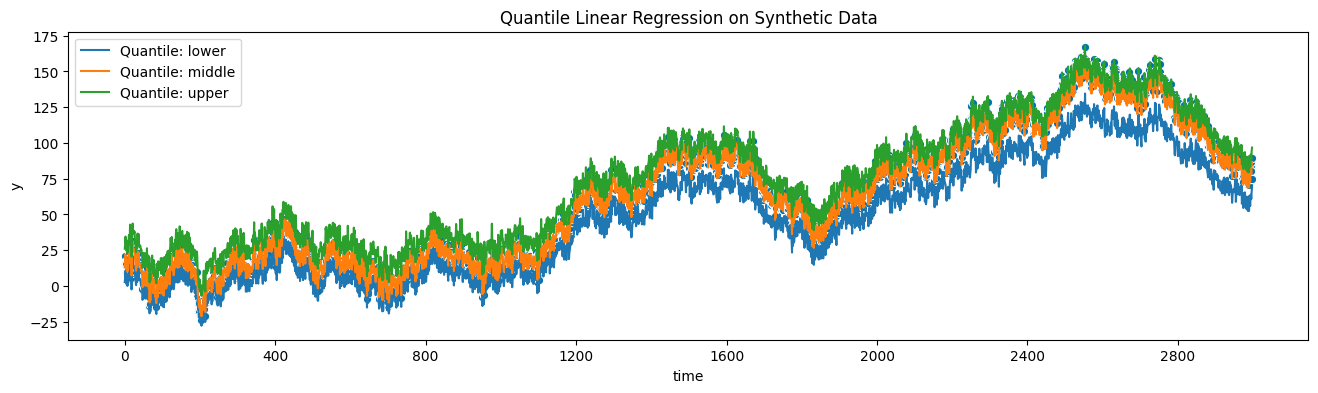

In [9]:
QLR_predictions = {}
        
# fit each prompted quantile and predict on all samples

QLR = QuantileLinearRegressor(quantiles=quantiles.values())
QLR.fit(df_train["y_lag"].to_numpy().reshape(-1,1), 
        df_train["y"].to_numpy())

y_pred = QLR.predict(df["y_lag"].to_numpy().reshape(-1,1))
print(y_pred.shape)

QLR_predictions["lower"] = y_pred[:, 0].reshape(1,-1,1)
QLR_predictions["middle"] = y_pred[:, 1].reshape(1,-1,1)
QLR_predictions["upper"] = y_pred[:, 2].reshape(1,-1,1)


QLR.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], QLR_predictions)
plt.title("Quantile Linear Regression on Synthetic Data")
plt.xlabel("time")

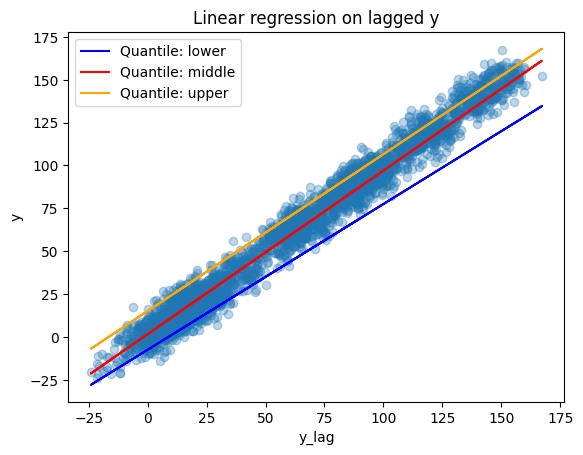

In [10]:
# this cell is to show the correlation between y_lag and y
plt.scatter(df["y_lag"], df["y"], alpha=0.3)
plt.plot(df["y_lag"], QLR_predictions["lower"].flatten(), color="blue",  label="Quantile: lower")

plt.plot(df["y_lag"], QLR_predictions["middle"].flatten(), color="red", label="Quantile: middle")
plt.plot(df["y_lag"], QLR_predictions["upper"].flatten(), color="orange", label="Quantile: upper")


plt.title("Linear regression on lagged y")
plt.xlabel("y_lag")
plt.ylabel("y")
plt.legend()
plt.show()

ACI

[11:26:49] WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun  ]8;id=127904;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=448430;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py#448\448]8;;\
                    for more info.)                                                                                

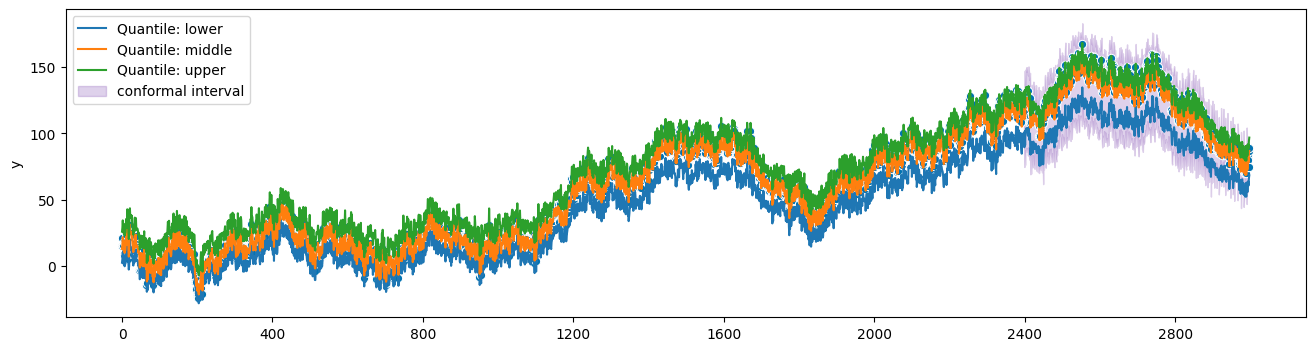

In [11]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(QLR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split, gamma=optimal_aci_gamma["linear"])
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QLR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QLR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QLR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_linear.loc[1] = metric.computeAll(model_name="Linear ACI").values()

<Figure size 640x480 with 0 Axes>

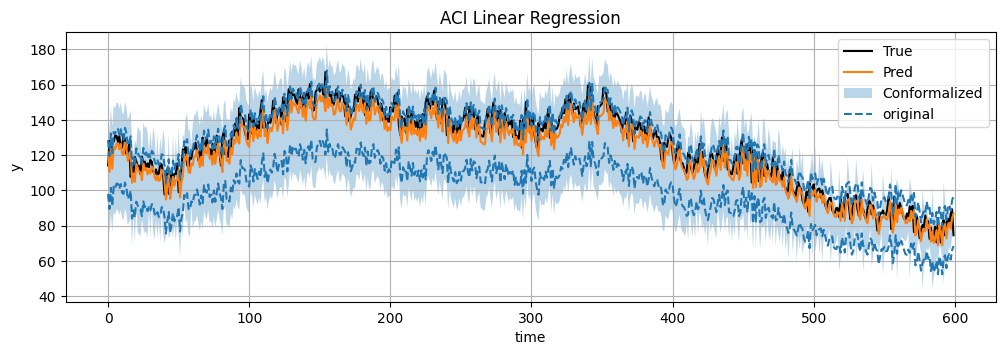

In [12]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QLR_predictions["middle"][0][df_test["t"],0],
               PI_low = QLR_predictions["lower"][0][df_test["t"],0], PI_hi = QLR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Linear Regression')

In [13]:
df_linear

,model_name,RMSE,PICP,PIAW,PINAW,CWC
1,Linear ACI,8.045551,0.951667,53.403027,0.551634,0.41386


## Quantile Forest

Define metrics

In [14]:
df_forest = pd.DataFrame({"model_name" : [],
                          "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [15]:
predictions = []

Quantile estimation

In [16]:
X_all, y_all = df["y_diff_lag"].to_numpy().reshape(-1,1), df["y_diff"].to_numpy()
X_train, y_train = df_train["y_diff_lag"].to_numpy().reshape(-1,1), df_train["y_diff"].to_numpy()
X_val, y_val = df_val["y_diff_lag"].to_numpy().reshape(-1,1), df_val["y_diff"].to_numpy()
X_test, y_test = df_test["y_diff_lag"].to_numpy().reshape(-1,1), df_test["y_diff"].to_numpy()

In [17]:
QFR = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=[0.05, 0.5, 0.95], max_depth=2, differencing=False)
QFR.fit(X_train, y_train)

In [18]:
y_pred = QFR.predict(X_all)
QFR_predictions = {}

2998it [00:20, 145.02it/s]


In [19]:
y_pred.shape

(2998, 3)

In [20]:
QFR_predictions["lower"] = y_pred[:, 0].reshape(1, -1, 1)
QFR_predictions["middle"] = y_pred[:, 1].reshape(1, -1, 1)
QFR_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)

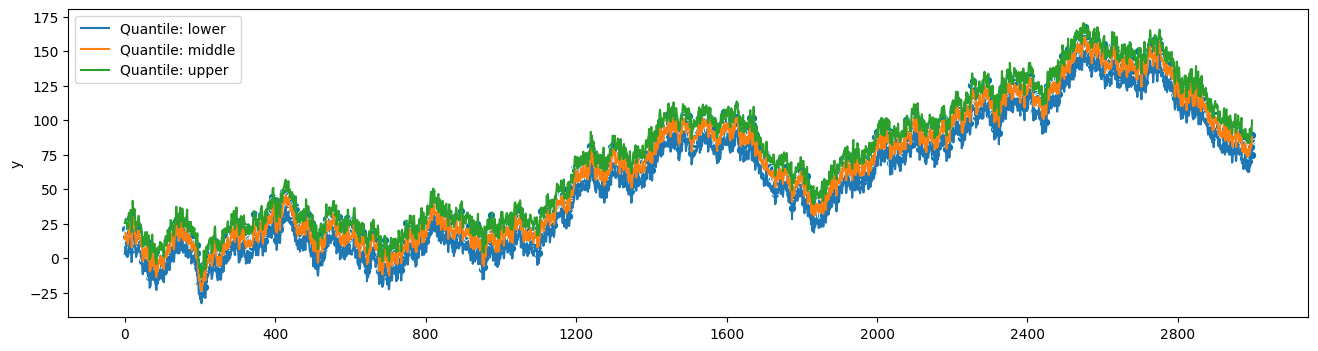

In [21]:
QFR.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], QFR_predictions)

ACI

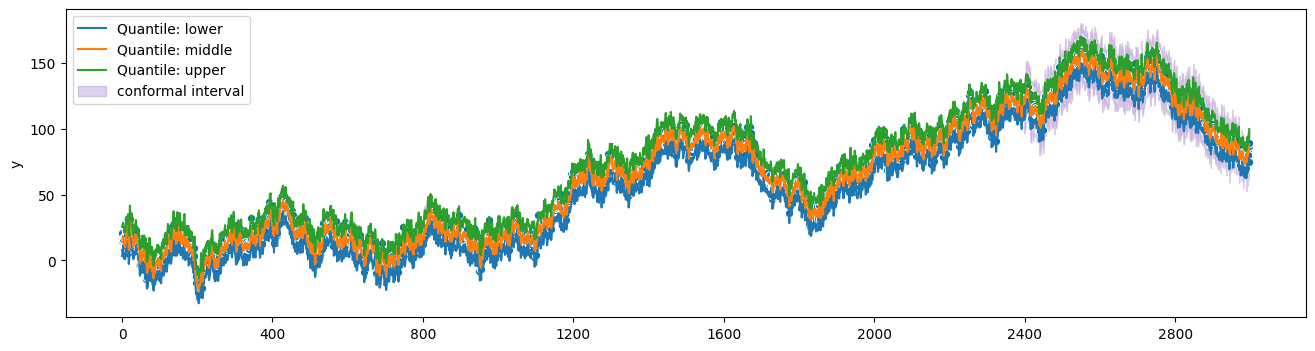

In [22]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(QFR_predictions, y_test=df_test["y"].to_numpy(), 
                                                                        y_val=df_val["y"].to_numpy(), T=T,
                                                                        tvt_split=tvt_split, gamma=optimal_aci_gamma["forest"])
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"].sort_index(), QFR_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((QFR_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), 
                 QFR_predictions["middle"][0][df_test["t"],0], 
                 conformal_intervals[:,0], 
                 conformal_intervals[:,1],)
df_forest.loc[1] = metric.computeAll(model_name="Forest ACI").values()

<Figure size 640x480 with 0 Axes>

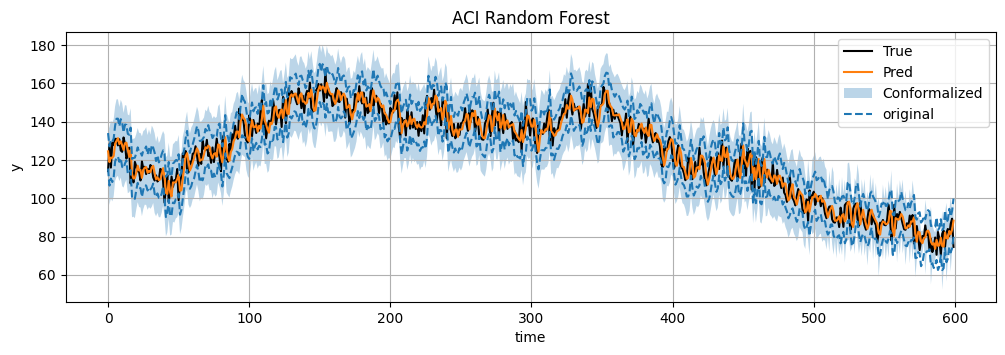

In [23]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= QFR_predictions["middle"][0][df_test["t"],0],
               PI_low = QFR_predictions["lower"][0][df_test["t"],0], PI_hi = QFR_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Random Forest')

## Neural Regression with QRNN

Define metrics

In [24]:
df_NN = pd.DataFrame({"model_name" : [],
                      "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})

In [25]:
predictions = []

In [26]:
quantiles

{'lower': 0.05, 'middle': 0.5, 'upper': 0.95}

Quantile estimation

In [27]:
layers = 4
neurons = 256
activation = "relu"
model = (layers, neurons, activation)
qrnn = QuantileNeuralRegressor(quantiles=list(quantiles.values()), n_inputs=1, model_params=model)

In [28]:
logs = qrnn.fit(df_train["y_lag"].to_numpy().reshape(-1,1), df_train["y"].to_numpy(), n_epochs=15)

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        11.634        
      2   0.0005         2.904        
      3   0.0005         2.236        
      4   0.0005         1.867        
      5   0.0005         1.757        
      6   0.0005         1.746        
      7   0.0005         1.728        
      8   0.0005         1.714        
      9   0.0005         1.664        
     10   0.0005         1.607        
     11   0.0005         1.535        
     12   0.0005         1.474        
     13   0.0005         1.478        
     14   0.0005         1.469        
     15   0.0005         1.441

In [29]:

y_pred = qrnn.predict(df["y_lag"].values.reshape(-1,1))

NN_predictions = {}
NN_predictions["lower"] = y_pred[:,0].reshape(1, -1, 1)
NN_predictions["middle"] = y_pred[:,1].reshape(1, -1, 1)
NN_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)


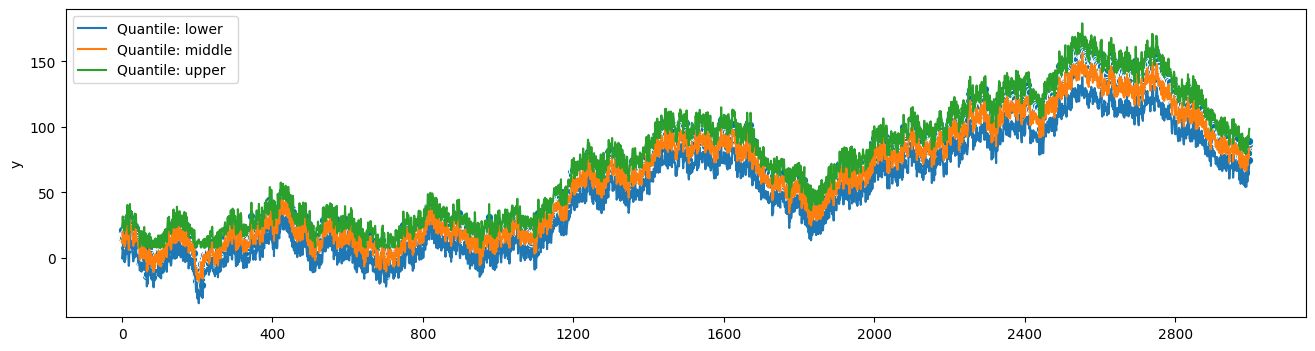

In [30]:
qrnn.plot_quantiles(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions)

ACI

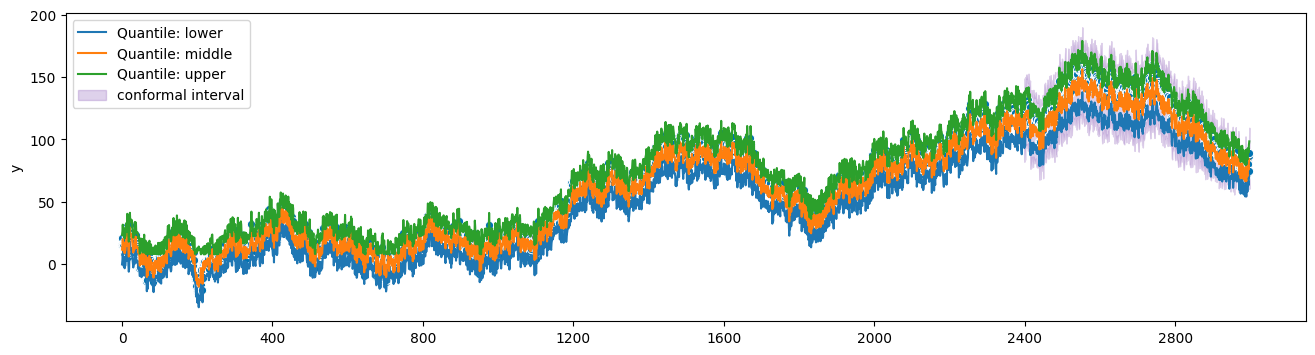

In [31]:
aci = ACI()
conformal_intervals = aci.create_conformal_interval(NN_predictions, df_test["y"].to_numpy(), 
                                                    df_val["y"].to_numpy(), T,
                                                    tvt_split=tvt_split, gamma=optimal_aci_gamma["neural"])
aci.plot_conformal_interval(df["t"].to_numpy().reshape(-1,1), df["y"], NN_predictions, 
                            df_test["t"].to_numpy().reshape(-1,1), 
                                conformal_intervals)

predictions.append((NN_predictions, conformal_intervals))

metric = Metrics(df_test["y"].to_numpy(), NN_predictions["middle"][0][df_test["t"].to_numpy(), 0], conformal_intervals[:,0], conformal_intervals[:,1],)
df_NN.loc[1] = metric.computeAll(model_name="NN ACI").values()

<Figure size 640x480 with 0 Axes>

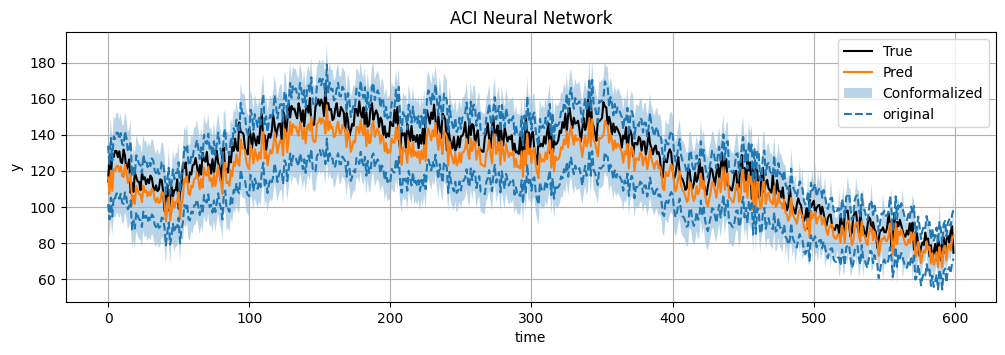

In [32]:
plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= NN_predictions["middle"][0][df_test["t"],0],
               PI_low = NN_predictions["lower"][0][df_test["t"],0], PI_hi = NN_predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI Neural Network')

# Comparison

In [33]:
df_linear

,model_name,RMSE,PICP,PIAW,PINAW,CWC
1,Linear ACI,8.045551,0.951667,53.403027,0.551634,0.41386


In [34]:
df_forest

,model_name,RMSE,PICP,PIAW,PINAW,CWC
1,Forest ACI,6.349287,0.98,38.388809,0.396542,0.498038


In [35]:
df_NN

,model_name,RMSE,PICP,PIAW,PINAW,CWC
1,NN ACI,10.375188,0.975,50.97718,0.526576,0.399911


## Tables

In [36]:
df_linear.to_csv(f"{dataset}_linear_300.csv")

In [37]:
df_forest.to_csv(f"{dataset}_forest_300.csv")

In [38]:
df_NN.to_csv(f"{dataset}_NN_300.csv")

GRID SEARCH

In [39]:
# scores_lin, gamma_lin = optimize_conformal(model_predictions=QLR_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

In [40]:
# scores_rf, gamma_rf = optimize_conformal(model_predictions=QFR_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)

In [41]:
# scores_nn, gamma_nn = optimize_conformal(model_predictions=NN_predictions, df=df, df_train=df_train, df_val=df_val, df_test=df_test, tvt_split=tvt_split, T=T)